In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

In [2]:
class FoodStorage:

    def __init__(self, startingInsectFood, startingLegacyFood, percentInsect, legacyFillUpAmount,
                 legacyRefillFrequency):
        """
        Args:
        startingInsectFood (int): amount of insect food in kg.
        startingLegacyFood (int): amount of "legacy" food in kg.
        percentInsect (float)   : percentage of insectfood in animalfeed.
        legacyFillUpAmount (int): amount of legacyfood added to storage
        legacyRefillFrequency (int): days until next addition of legacy food to storage 
        
        """
        #self.co2PerInsect = 1
        #self.co2PerLegacy = 2
        #self.legacyFillUpAmount = legacyFillUpAmount
        #self.legacyRefillFrequency = datetime.timedelta(legacyRefillFrequency)
        #self.legacyNextRefill = currentDate + self.legacyRefillFrequency
        self.insectFood = startingInsectFood
        #self.legacyFood = startingLegacyFood
        #self.percentInsect = percentInsect
        #self.totalFood = self.insectFood + self.legacyFood
        #self.minFood = (self.totalFood, currentDate)

    def eatFood_old(self, eaten):
        """
        Args:
        eaten (int/float): Amount eaten in kg .
        
        Returns: 
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = 0
        if self.insectFood >= eaten*self.percentInsect:
            self.insectFood -= eaten*self.percentInsect
            self.legacyFood -= eaten*(1-self.percentInsect)
            co2 += eaten*self.percentInsect*self.co2PerInsect
            co2 += eaten*(1-self.percentInsect)*self.co2PerLegacy
        else:
            self.legacyFood -= eaten
            co2 = eaten*self.co2PerLegacy
        self.totalFood = self.insectFood + self.legacyFood
        if self.totalFood < self.minFood[0]:
            self.minFood = (self.totalFood, currentDate)
        return co2
    
    def eatFood(self,foodlist,noeating,insectfood=0):
        """
        Args:
        eaten (int/float): Amount eaten in kg .

        Returns: 
        Price (float): Price
        """

        # create price lookup
        columns = ['Maxigris7','Hedegaard16/17 Drægtig','Hedegaard16/17 Die','Hedegaard16/17 Polte','Hedegaard16/17 FLM',
              'Minigris4']
        price = [2.21, 1.47, 1.76, 1.58, 4.26, 4.41]
        price_lookup = pd.Series(price,index=columns)
        
        co2PerKgPig = 2.4
        vækst = 30-9
        co2 = (vækst*co2PerKgPig/84)*noeating

        # calculate 
        self.insectFood = self.insectFood - insectfood*noeating
        price = 0
        for n in range(noeating):
            for i in range(len(foodlist)):
                if i == 0 or i ==5:
                    price += price_lookup.iloc[i]*foodlist[i]

        return price, co2
        
    def addInsectFood(self, add):
        """
        Args:
        add (int): amount of insectfood added to storage.
        """
        self.insectFood += add
        
    def addLegacyFood(self, currentDate):
        """
        Args:
        add (int): amount of "legacy" food added to storage.
        """
        if currentDate == self.legacyNextRefill or currentDate > self.legacyNextRefill:
            self.legacyFood += self.legacyFillUpAmount
            self.legacyNextRefill = currentDate + self.legacyRefillFrequency

In [3]:
class InsectFarm:
    def __init__(self, sqrMeter, insectType, currentDate, target):
        """
        Args:
        sqrMeter (int): Size of sqr. meters for insectfarm.
        insectType (string): Type of insect ("bi" or "larve").
        target (FoodStorage obj.): Where to put harvested insects.
        """
        insects = {'cricket': (25, 42), 'larve': (18.7, 14)} #(food per sqmtr, time to harvest)18.7
        self.nutrition = insects[insectType][0]*sqrMeter
        self.harvestFrequency = datetime.timedelta(days=insects[insectType][1])
        self.nextHarvest = currentDate + self.harvestFrequency
        self.target = target
        self.consumption = 1*sqrMeter
        
    def harvest(self,currentDate):
        """
        Return:
        self.nutrition (int/float): Amount harvested in kg.
        """
        if currentDate == self.nextHarvest or currentDate > self.nextHarvest:
            self.target.addInsectFood(self.nutrition)
            self.nextHarvest = currentDate + self.harvestFrequency
        
        return self.target.insectFood
        
        

In [4]:
class Piggery:
    def __init__(self, noPigletPerLitter, litterFrequency, InsectPercent, noSows,
                 pigletTime, sellFrequency, target, currentDate):
        """
        Args:
        noPigletPerLitter      (int): Amount of piglets added per litter
        litterFrequency        (int): Frequency litters are added
        InsectPercent        (float): Food per piglet per day (kg)
        noSows                 (int): Number of sows
        pigletTime             (int): Number of days before a piglet becomes a pig
        sellFrequency          (int): Days before a pig is sold
        target    (FoodStorage obj.): Where to get food from
        currentDate      (time obj.): The current simulated date           
        # https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0141878.s001
        # Link with info regarding pig gestation
        """
        self.piglets = []
        self.pigs = []
        self.noPiglets = 0
        self.noPigs = 0
        self.noSold = 0
        self.noPigletPerLitter = noPigletPerLitter
        self.noSows = noSows
        #self.startNoPiglets = startNoPiglets
        #self.gestationFrequency = datetime.timedelta(int((gestationTime+pigletTime)/litters))
        self.pigletTime = datetime.timedelta(pigletTime)
        self.nextLitter = currentDate
        self.litterFrequency = datetime.timedelta(litterFrequency)
        self.sellFrequency = datetime.timedelta(sellFrequency)
        
        #
        self.sowNutritionNeeds = [0,33660/(300*56),27180/(300*56),17220/(300*56),0,0]
        self.pigNutritionNeeds,self.pigInsectAmount = self._calcPigNutritionNeeds(InsectPercent)
        self.InsectPercent = InsectPercent
        #
        
        self._addPiglets(noPigletPerLitter,currentDate)
        #self._addPigs(startNoPigs,currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        self.lastUpdateDate = currentDate
        self.target = target
        
    def _addPiglets(self, noPiglets,currentDate):
        """
        Args:
        noPiglets         (int): Number of piglets.
        currentDate (time obj.): The current simulated date.
        """
        if currentDate == self.nextLitter or currentDate > self.nextLitter:
            self.piglets.append((noPiglets,currentDate + self.pigletTime))
            self.nextLitter = currentDate+ self.litterFrequency
    
    def _addPigs(self,noPigs,currentDate):
        """
        Args:
        noPigs            (int): Number of pigs.
        currentDate (time obj.): The current simulated date.
        """
        self.pigs.append((noPigs,currentDate + self.sellFrequency))
        
    
    def _calcPigNutritionNeeds(self,percentinsect):

        maxigris7 = (58440-(58440*percentinsect))/(((14076/365)*56)*56)
        minigris4 = (875-(875*percentinsect))/(((14076/365)*56)*56)
        zink = 7720/(((14076/365)*56)*56)
        foodlist = [maxigris7,0,0,0, zink, minigris4]
        insectfood = (58440*percentinsect)/(((14076/365)*56)*56) + (875*percentinsect)/(((14076/365)*56)*56)

        return foodlist, insectfood
        
    def _movePiglets(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        """
        noPiglets = 0
        for i,litter in enumerate(self.piglets):
            if currentDate == litter[1] or currentDate > litter[1]:
                noPiglets += litter[0]
                self.piglets.pop(i)
                
        #removing piglet -> pig step        
        self._addPigs(noPiglets,currentDate)
        
    def _sellPigs(self, currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        """
        for i,litter in enumerate(self.pigs):
            if currentDate == litter[1]:
                self.noSold += self.pigs[i][0]
                self.pigs.pop(i)

    def _eat(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        
        Returns:
        amountEaten (int): Amount of food eaten
        co2       (float): CO2 value of eaten food
        """
        days = (currentDate - self.lastUpdateDate).days +1
        price_pig,co2 = self.target.eatFood(self.pigNutritionNeeds,self.noPigs,self.pigInsectAmount)
        price_sow,_ = self.target.eatFood(self.sowNutritionNeeds,self.noSows)
        price = price_pig + price_sow
        co2 = co2 * (1-self.InsectPercent)
        self.lastUpdateDate = currentDate
        
        #return amountEaten, co2
        return price, co2
                
    def _updateNoPigs(self):
        noPigs = 0
        for litter in self.pigs:
              noPigs +=litter[0]
                
        self.noPigs = noPigs
                
    def _updateNoPiglets(self):
        noPiglets = 0
        for litter in self.piglets:
              noPiglets +=litter[0]
        
        self.noPiglets = noPiglets
    
    def update(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        
        Returns:
        amountEaten (int): Amount of food eaten
        co2       (float): CO2 value of eaten food
        noPiglets   (int): Number of piglets in piggery
        noPigs   (int): Number of pigs in piggery
        """
        self._addPiglets(self.noPigletPerLitter,currentDate)
        self._movePiglets(currentDate)
        self._sellPigs(currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        #amountEaten,co2 = self._eat(currentDate)
        price, co2 = self._eat(currentDate)
        
        #return amountEaten, co2, self.noPiglets, self.noPigs
        return price, co2, self.noPiglets, self.noPigs

In [5]:
def Simulate():
    # Prepare dates
    currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
    stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')

    # Prepare objects
    food = FoodStorage(startingInsectFood, startingLegacyFood, percentInsect,legacyFillUpAmount,legacyRefillFrequency)
    farm = InsectFarm(sqrMeter, insectType,currentDate=currentDate, target=food)
    piggery = Piggery(noPigletPerLitter, litterFrequency, percentInsect, noSows,
                      pigletTime, sellFrequency, target=food,currentDate=currentDate)


    # Prepare dataframe
    df = pd.DataFrame(columns=['Month', 'Piglets', 'Pigs','Insect storage','Price','CO2'])
    df = df.set_index('Month')
    price = 0

    # Loop over the selected dates
    while currentDate != stopDate and currentDate < stopDate:

        #eaten,co2,piglets,pigs = piggery.update(currentDate)
        price,co2,piglets,pigs = piggery.update(currentDate)

        # Add month/year(Sep19) row if not already present.
        if currentDate.strftime("%d%b%y") not in df.index.tolist():
            df.loc[currentDate.strftime("%d%b%y")] = [0,0,0,0,0]

        #Insect farm
        df.loc[currentDate.strftime("%d%b%y")]['Insect storage'] += farm.harvest(currentDate)

        # Foodstorage
        #food.addLegacyFood(currentDate)  

        # Piggery
        df.loc[currentDate.strftime("%d%b%y")].Piglets += piglets
        df.loc[currentDate.strftime("%d%b%y")].Pigs += pigs
        df.loc[currentDate.strftime("%d%b%y")].Price += price
        df.loc[currentDate.strftime("%d%b%y")].CO2 += co2

        currentDate = currentDate+datetime.timedelta(days=1)
        
    return df

# OPGAVER!
Piglets = sælges
årssøer = 360 (27 om året)


In [6]:
###############Settings####################
### Date settings ###
startdate = '01Jan2019'    # Start date as a string                 
stopdate = '01Jan2020'     # End date as a string
simulationInterval = 7     # Number of days per simulation point

### Food ###
startingInsectFood = 0    # Amount of insect food at day 0
startingLegacyFood = 0    # Amount of legacy food at day 0
percentInsect = 0.10      # Percent insects mixed in the food
legacyFillUpAmount = 30    # Amount of legacy food filled up at refill
legacyRefillFrequency = 7  # The frequency of legacy food refill in days

### Insect farm ###
sqrMeter=(30/3)*20        # Sqrmeters where insects are farmed
insectType='larve'         # Type of insect farmed

#### Piggery ###
noPigletPerLitter=int(11730/26)      # Number of piglets per litter
noSows = 300               # No sows producing litters
litterFrequency=14         # Piglets nutrition needs
pigletTime = 32            # Time piglets need to grow to become pigs
sellFrequency=84           # Time pigs need to be fed before they are sold 
###########################################

In [7]:
percentInsect = 0
df0 = Simulate()

percentInsect = 0.10 
df10 = Simulate()

percentInsect = 0.15
df15 = Simulate()

percentInsect = 0.20
df20 = Simulate()

In [8]:
#columns = ['10% insectfood','15% insectfood','20%']
co2 = pd.DataFrame()
co2['0% insectfood'] = df0.CO2
co2['10% insectfood'] = df10.CO2
co2['15% insectfood'] = df15.CO2
co2['20% insectfood'] = df20.CO2

co2.index = pd.to_datetime(co2.index)
co2 = co2.groupby(pd.Grouper(freq="M")).agg(np.sum)
co2.index = co2.index.strftime('%B')


price = pd.DataFrame()
price['0% insectfood'] = df0.Price
price['10% insectfood'] = df10.Price
price['15% insectfood'] = df15.Price
price['20% insectfood'] = df20.Price

price.index = pd.to_datetime(price.index)
price = price.groupby(pd.Grouper(freq="M")).agg(np.sum)
price.index = price.index.strftime('%B')

insectStorage = pd.DataFrame()
insectStorage['0% insectfood'] = df0['Insect storage']
insectStorage['10% insectfood'] = df10['Insect storage']
insectStorage['15% insectfood'] = df15['Insect storage']
insectStorage['20% insectfood'] = df20['Insect storage']

insectStorage.index = pd.to_datetime(insectStorage.index)


piggerydf = pd.DataFrame()
piggerydf[['Piglets', 'Pigs']] = df10[['Piglets', 'Pigs']]

piggerydf.index = pd.to_datetime(piggerydf.index)




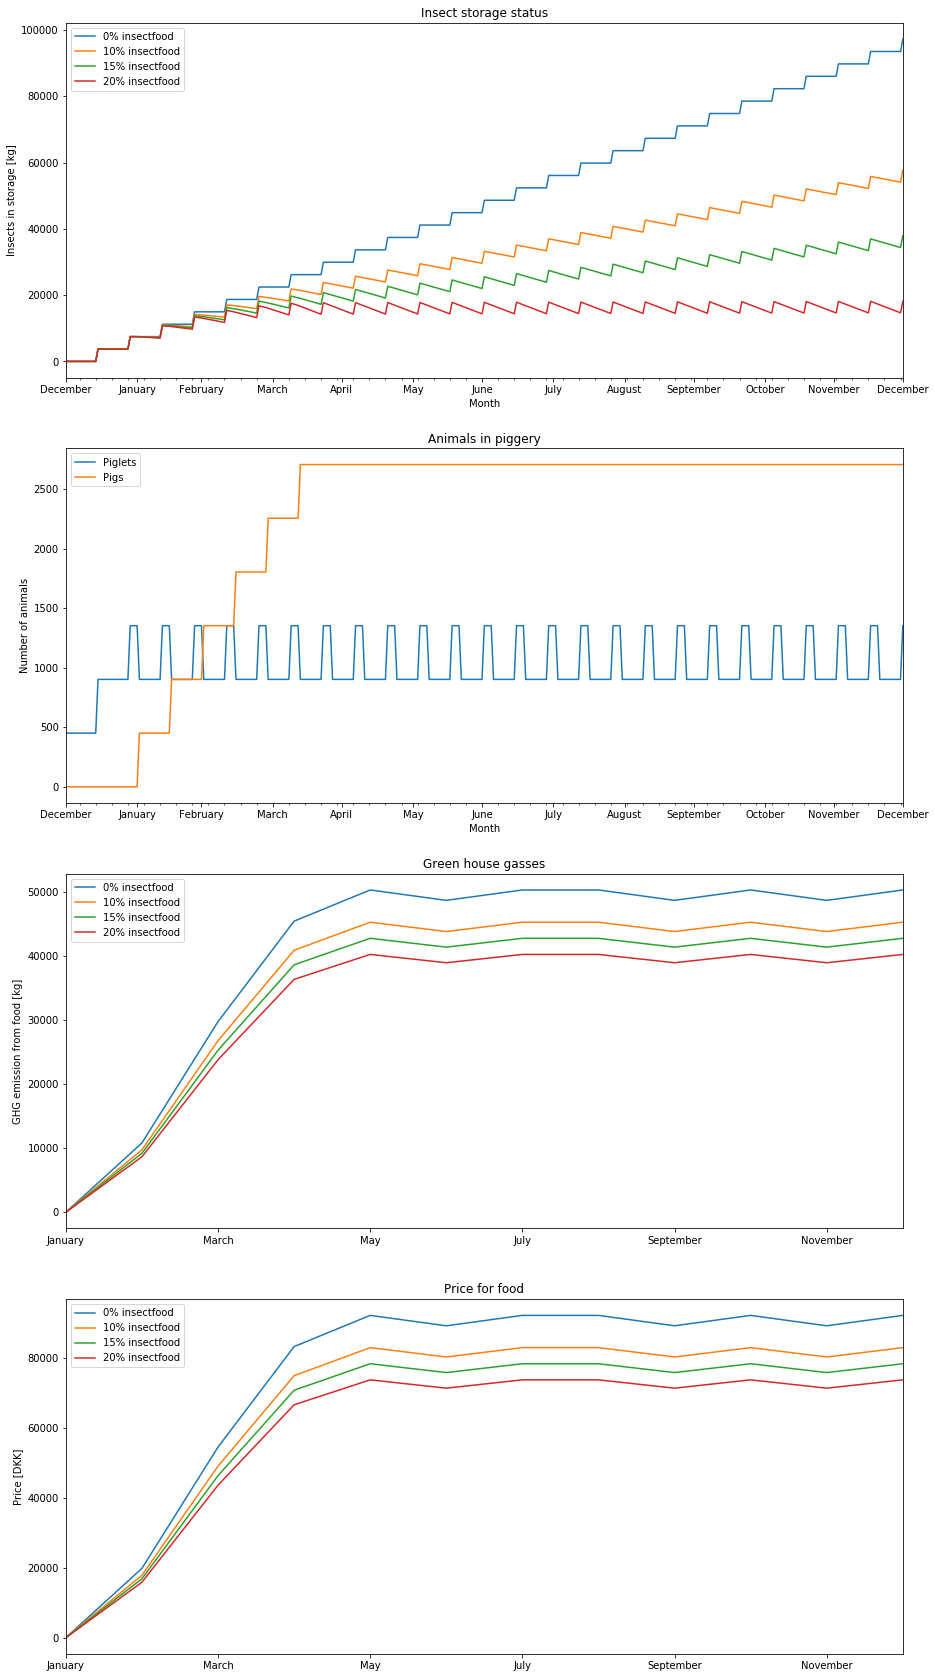

In [9]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(4, 2)

plt.figure(figsize=(15,30));
#plt.figure()
ax = plt.subplot(gs[0, :]) # row 0, col 0
insectStorage.plot(ax=ax);
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
plt.title("Insect storage status")
plt.ylabel("Insects in storage [kg]")
#df15[['Insect storage']].plot(ax=ax);
#df20[['Insect storage']].plot(ax=ax);

ax = plt.subplot(gs[1, :]) # row 0, col 1

#df10[['Piglets', 'Pigs']].plot(ax=ax);
piggerydf.plot(ax=ax)
#ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))

#plt.xticks(locs, labels)
#piggerydf.plot(ax=ax)
plt.title("Animals in piggery")
plt.ylabel("Number of animals")
#df15[['Piglets', 'Pigs']].plot(ax=ax);

ax = plt.subplot(gs[2, :]) # row 1, span all columns
#co22 = pd.to_datetime(df.index)
#co2.groupby(pd.Grouper(freq="M")).plot(ax=ax);
co2.plot(ax=ax);
plt.title("Green house gasses")
plt.ylabel("GHG emission from food [kg]")
#df10[['CO2']].plot(ax=ax);
#df15[['CO2']].plot(ax=ax);
#df20[['CO2']].plot(ax=ax);

ax = plt.subplot(gs[3, :]) # row 2, span all columns
price.plot(ax=ax);
plt.title("Price for food")
plt.ylabel("Price [DKK]")
#df10[['Price']].plot(ax=ax);
#df15[['Price']].plot(ax=ax);
#df20[['Price']].plot(ax=ax);
plt.show()